<h1><center>Exploring the KMeans Function</center></h1>


In [2]:
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from num2words import num2words

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


<h1><center>Notebook Goal:</center></h1>
<h2><center>Create a basic understanding of how to convert News Headlines into K Clusters</h2></center>

<center>We will be looking at ABC news headlines from 2003-2019.
What we will attempt to do is classify these headlines into "Clusters".
Note that we don't have a column available of labeled groups.
This means when we cluster the headlines it is considered "Unsupervised Learning".</center>

In [3]:
df = pd.read_csv("abcnews-date-text.csv")
df.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [4]:
df.tail()

,publish_date,headline_text
1186013,20191231,vision of flames approaching corryong in victoria
1186014,20191231,wa police and government backflip on drug amne...
1186015,20191231,we have fears for their safety: victorian premier
1186016,20191231,when do the 20s start
1186017,20191231,yarraville shooting woman dead man critically ...


### Let's start with a subset of the data 
    We will look at December 2019 headlines since we can remember these ocurring

In [5]:
df['publish_date']= df['publish_date'].astype(str)
df = df[df.publish_date.str.contains('201912')]
df

,publish_date,headline_text
1183547,20191201,5yo girl dies after being found unresponsive i...
1183548,20191201,advent calendars christmas tradition everyone ...
1183549,20191201,army veteran ptsd dog complains at qantas trea...
1183550,20191201,asx soars to new high as economy is rooted in ...
1183551,20191201,australia vs pakistan second test day three ad...
...,...,...
1186013,20191231,vision of flames approaching corryong in victoria
1186014,20191231,wa police and government backflip on drug amne...
1186015,20191231,we have fears for their safety: victorian premier
1186016,20191231,when do the 20s start


### Now for the fun part - Cleaning the Text

In [6]:
def convert_lower_case(document):
    '''
    Params: A Document
    --------------------------------------------
    Convert each document to lowercase characters
    '''
    document = np.char.lower(document)
    return document


In [7]:
def remove_apostrophe(document):
    '''
    Params: A Document
    --------------------------------------------
    Remove the apostrophe from every document
    '''
    document = np.char.replace(document, "'", "")
    return document

In [8]:
def remove_punctuation(document):
    '''
    Params: A Document
    --------------------------------------------
    Remove every punctuation symbol from every document
    '''
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        document = np.char.replace(document, i, '')
    return document


In [9]:
def number_to_words(document):
    '''
    Params: A Document
    --------------------------------------------
    Convert numbers to word form in each docuemnt
    '''
    tokens = word_tokenize(document)
    for word in tokens:
        if word.isnumeric():
            num_word = num2words(word)
            document = document.replace(word, num_word)
    return document

In [10]:
def remove_stop_words(document):
    '''
    Params: A Document
    --------------------------------------------
    Remove stop words from each document
    '''
    stop_words = stopwords.words('english')
    new_text = ''
    tokens = word_tokenize(document)
    for word in tokens:
        if word not in stop_words:
            new_text = new_text + " " + word
    return new_text
  

In [11]:
def remove_single_characters(document):
    '''
    Params: A Document
    --------------------------------------------
    Remove characters of length 1 from each document
    '''
    new_text = ""
    tokens = word_tokenize(document)
    for word in tokens:
        if len(word) > 1:
            new_text = new_text + " " + word
    return new_text


In [12]:
def preprocess(df, column):
    '''
    Params: A dataframe, A column to process
    --------------------------------------------
    Run the formulas above for a select column in a dataframe
    '''
    df[column] = df[column].apply(lambda doc: convert_lower_case(doc))
    print('Words have been lowercased')
    
    df[column] = df[column].apply(lambda doc: remove_apostrophe(doc))
    print('Apostrophe Removed')
    
    df[column] = df[column].apply(lambda doc:remove_punctuation(doc))
    print('Punctuation Removed')
    
    df[column] = df[column].apply(lambda doc:number_to_words(doc))
    print('Numbers converted to Words')
    
    df[column] = df[column].apply(lambda doc:remove_stop_words(doc))
    print('Stopwords Removed')
    
    df[column] = df[column].apply(lambda doc:remove_single_characters(doc))
    print('Single Characters Removed')
    
    return df

<p>As boring as the text cleaning is, it'll improve our results. 
Now lets implement the preprocess functions. Otherwise KMEANS will pick up random "words" or "tokens" as unique because they are not real words and are never duplicated again throughout the dataframe, which will mess up the entire results.</p>

In [13]:
df = preprocess(df, 'headline_text')

Words have been lowercased
Apostrophe Removed
Punctuation Removed
Numbers converted to Words
Stopwords Removed
Single Characters Removed


### Beautiful all of the punctuation, stopwords, among other annoyances have been removed.
### Ok, cool. So we can start building the KMEANS function now, right?  Well no


In [14]:
df

,publish_date,headline_text
1183547,20191201,5yo girl dies found unresponsive car
1183548,20191201,advent calendars christmas tradition everyone...
1183549,20191201,army veteran ptsd dog complains qantas treatment
1183550,20191201,asx soars new high economy rooted mediocrity
1183551,20191201,australia vs pakistan second test day three a...
...,...,...
1186013,20191231,vision flames approaching corryong victoria
1186014,20191231,wa police government backflip drug amnesty bins
1186015,20191231,fears safety victorian premier
1186016,20191231,20s start


## Let's first define what KMEANS is and does:
KMEANS is all about computing the sum of the squared distance between data points and "centroids".
   ## Preparing Kmeans:
    -The first step in the algorithim is to specify how many K clusters you want
    -Then define K centroids compeletely randomly.

   ## Distance Part:
    -Next compute the sum of the squared distance between each record and all centroids.
    -From there, assign each record to the CLOSEST centroid based on the distance
    -Finally, compute the average of the clusters
        -Hint: This will move the centroids to a more accurate location
    -Then repeat these steps again and again, until the centroids remain the same

Seems pretty simple, no?

But how does a computer perform this function on TEXT data?

Well we will have to convert the text into numbers in the form of vectors.

<h1><center> Introducing TF-IDF </h1><center>

### We will use existing methods to understand how TFIDF works

In [15]:
def tfidf(df, header):
    '''
    Params: A dataframe, a column to vectorize
    --------------------------------------------
    Call the vectorizer
    Fit transform the chosen column in the dataframe
    Call interesting statistics
    '''
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df[header])

    idf = vectorizer.idf_
    
    names_weights_dict = (dict(zip(vectorizer.get_feature_names(), idf)))
    frame = pd.DataFrame(names_weights_dict.items())
    
    return vectorizer, tfidf_matrix, vectorizer.vocabulary_, tfidf_matrix.toarray(), frame
 

### TFIDF stands for Term Frequency - Inverse Document Frequency

In [16]:
vectorizer, tfidf_matrix, vocabulary, array, idf_frame = tfidf(df, 'headline_text')

### Let's set some reasoning:

    First assumption: We need to create a vector for each record. We can't vectorize on soley the words 
    of a record, because then each vector will be different lengths. If the vectors are different lengths 
    then we won't be able to do basic vector subtraction in our distance formula.

    Looking below we see scikit's TfidfVectorizer took every word known from every record in our headline 
    column of our dataset. Each word is assigned a unique ID. 

    Remember this, because a rows record has a vector length equal to the length of this vocabulary list. 
    Every row in our data has this vector of equal length. 

    The 0th term in the vocabulary dictionary is related to the 0th term in the rows vector. Therefore the 
    ith term in the vocabulary dictionary is related to the ith term in the rows vector.

    Now the question is, what are the values of the vector?
    
    The answer comes from a formula called TFIDF (Term Frequency Inverse Document Frequency)

### Showing each word of our dataset is assigned a unique ID

In [17]:
example_vocab = {k: vocabulary[k] for k in sorted(vocabulary.keys())[1000:1010]} #Used this as an example range, feel free to test whatever range

example_vocab

{'coaches': 1000,
 'coaching': 1001,
 'coag': 1002,
 'coal': 1003,
 'coalition': 1004,
 'coast': 1005,
 'coastal': 1006,
 'coasts': 1007,
 'coates': 1008,
 'cobar': 1009}


### TF-IDF Formula Breakdown:
    tf-idf(t, d) = tf(t, d) * log(N/(df + 1))
    where t = term - a word
          d = document (record, row, however you wish to call it)
          df = document frequency
          N = number of records - ENTIRE SET of documents
          tf(t, d) = frequency of a word(t) in a document(d) / number of words in document(d)
          df(t) = frequency of a word (t) in the ENTIRE SET of documents
    
    Look at the second part of the formula log(N/(df+1)), this is called "IDF" - Inverse Document Frequency.
    This means that a very common word will have a very low score because document freuqnecy (df) is normalized
    by dividing it by the N - number of records. IDF contains a log in order to normalize our scores.
    
    To help visualize this lets think of an example. Suppose a document contains the word "spotify". 5 of the 12
    words in that document is the word "spotify". Therefore the TF is 5/12. That is then mulitplied by the IDF.
    Well, lets assume spotify NEVER occurs again in the rest of the dataset and we have 1,000 records. Therefore,
    the IDF is log((1,000)/(5 + 1)) = log(166.67) = 2.22. Therefore tf-idf("spotify",d) = 5/12 * 2.22 = .925. 
    
    That is a relaitvely high score, because the .925 represents the unqiuness of the word "spotify" to that
    document. Had it only appeared once in the document the TF-IDF score would be much lower. Had "spotify"
    appeared in more often in the entire N, then TF-IDF score would be much lower.
    
    As you can begin to see TF-IDF is a tremendous formula to help build vector values on a set of documents.
    The formula captures the uniqueness, importance of a word to that document. This helps us begin to build
    clusters

### Showing the resulting vectors after TFIDF has been applied
    The value of the ith term in the vector is the ith term in the vocbaulary.
    Notice all of the zeroes in the vectors. Because our vocbulary is so large, the Term Frequency 
    for a term is likely to be zero. Remembering the formula TF*IDF, 0*IDF will always be zero. Trust 
    me that not every value in those vectors are zero.

In [18]:
'''
Showing that a vector is equal length to that of the vocabulary length
Therefore proving that a the value of the ith term in a vector is the ith
term in the vocbaulary
'''
print(len(array[0])) #A vector of a document has a length of 24,551
print(len(vocabulary)) #The length of our vocabulary is 24,551
print(array) #This all the vectors and there values

5664
5664
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Finding the Best K

#### Find the Elbow

    To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion.
    Inertia: The sum of squared distances of samples to their closest cluster center.

In [19]:
def kmeans_optimizer(matrix, K=range(1,400)):
    '''
    Params: The tfidf matrix, A range of K's
    -----------------------------------------------------------
    Plot the sum of squared distances (euclidean) at each K
    Helps guide us to the optimal K
    '''
    Sum_of_squared_distances = []
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(matrix)
        Sum_of_squared_distances.append(km.inertia_)
        
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

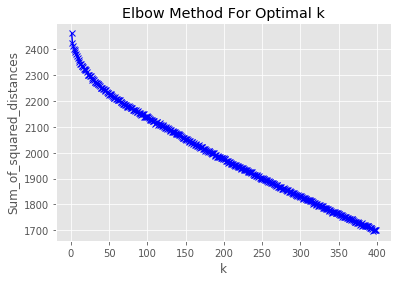

In [321]:
kmeans_optimizer(tfidf_matrix)

### Fit Kmeans
###### Finding the optimal centroids for our K
    We now begin to fit Kmeans
    This means we first should state the max amount of times Kmeans should iterate
    to find a centroid. This means that at a max of a 100 times, the function will cluster
    the records to a centroid. Then take the new center of all those assigned to a cluster,
    then repeat those steps until a definitive center has been assigned.
    - In our case we max iterate 100 times
    
    Next we should state the number of time we want to start at a set of centroids.
    - In our case we fit our data to 10 different starting points then begin
    the iterative process.
    
    The Kmeans fitted with the lowest inertia is chosen.

In [322]:
def kmeans_func(matrix, vectorizer, k=30):
    '''
    Params: A dataframe, the tfidf matrix, the vectorizer, K clusters
    ---------------------------------------------------------------
    Utilize the KMeans function:
        With:
        n_clusters is equal to the input K
        A max of 100 iterations
        Number of initilizations at different starting centroids - 30
        Verbose - Means print out steps of the function
    
    Because verbose is called, the function will print the intertia of
    the resulting centroids to the datapoints
    '''
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=5,
                verbose=1)
    km.fit(matrix)
    return km

In [323]:
our_km = kmeans_func(tfidf_matrix, vectorizer, k=30)

Initialization complete
Iteration  0, inertia 4420.258
Iteration  1, inertia 2319.992
Iteration  2, inertia 2307.613
Iteration  3, inertia 2302.971
Iteration  4, inertia 2299.013
Iteration  5, inertia 2296.369
Iteration  6, inertia 2294.236
Iteration  7, inertia 2293.566
Iteration  8, inertia 2293.339
Iteration  9, inertia 2292.995
Iteration 10, inertia 2292.838
Iteration 11, inertia 2292.764
Iteration 12, inertia 2292.744
Converged at iteration 12: center shift 0.000000e+00 within tolerance 1.758575e-08
Initialization complete
Iteration  0, inertia 4433.535
Iteration  1, inertia 2325.964
Iteration  2, inertia 2308.403
Iteration  3, inertia 2301.099
Iteration  4, inertia 2297.513
Iteration  5, inertia 2294.941
Iteration  6, inertia 2292.183
Iteration  7, inertia 2290.371
Iteration  8, inertia 2289.163
Iteration  9, inertia 2288.511
Iteration 10, inertia 2288.326
Iteration 11, inertia 2288.233
Iteration 12, inertia 2288.183
Converged at iteration 12: center shift 0.000000e+00 within tol

### Now it's time to add our Kmeans results to the existing DataFrame

    Simply create a new column to the existing DataFrame called "Cluster" which is the 
    kmeans labels.
    
    For further analysis, if you want, note that I added a terms_df that contains the top 10
    terms of a cluster. Do with that what you want.

In [324]:
def df_plus_kmeans(df, fitted_km, k=30):
    '''
    Params:
    A fitted Kmeans object
    K clusters
    ----------------------------------
    Add a new column to a dataframe called Cluster which is the cluster
    the row of text belongs to
    
    Print the cluster id and the top 10 terms that represent that cluster
    '''
    df['Cluster'] = our_km.labels_
    print("Top terms per cluster:")
    order_centroids = our_km.cluster_centers_.argsort()[:, ::-1] #Order the centroids so it is in order when we print
    terms = vectorizer.get_feature_names() #Get the feature names to indx
    term_df = pd.DataFrame() #Use to create a terms dataframe 
    terms_list = []
    cluster_list = []
    for i in range(k):
        print("Cluster {}:".format(i))
        for ind in order_centroids[i, :10]:
            print(' {}'.format(terms[ind]))
            terms_list.append(terms[ind])
            cluster_list.append(i)
    term_df["term"] = terms_list
    term_df["cluster"] = cluster_list
    return df, term_df

### Perfect now we can see the top 10 terms of each cluster

In [325]:
final_df, terms_df = df_plus_kmeans(df, our_km, k=30)

Top terms per cluster:
Cluster 0:
 climate
 people
 work
 life
 indigenous
 scott
 state
 morrison
 change
 care
Cluster 1:
 says
 us
 china
 trade
 uyghur
 needs
 iraq
 seals
 police
 navy
Cluster 2:
 australia
 rugby
 radio
 heatwave
 new
 folau
 israel
 zealand
 south
 swelter
Cluster 3:
 smoke
 sydney
 bushfires
 nsw
 haze
 bushfire
 due
 weather
 pollution
 change
Cluster 4:
 thousand
 two
 nineteen
 twenty
 best
 year
 years
 eve
 stories
 news
Cluster 5:
 briefing
 morning
 december
 sydney
 news
 tas
 tasmania
 dec
 wednesday
 thursday
Cluster 6:
 brisbane
 rain
 east
 severe
 heat
 south
 bom
 queensland
 brings
 storm
Cluster 7:
 stories
 top
 abc
 news
 zoo
 file
 fight
 fighter
 fighters
 fighting
Cluster 8:
 five
 record
 high
 street
 hot
 heatwave
 victoria
 weather
 twenty
 forty
Cluster 9:
 trial
 claremont
 serial
 killings
 murder
 witness
 rebecca
 telstra
 glennon
 ciara
Cluster 10:
 white
 island
 volcano
 zealand
 new
 eruption
 victims
 bodies
 nz
 whakaari
Clus

### Even better, now we have a DataFrame of a cluster for each headline

In [326]:
final_df

,publish_date,headline_text,Cluster
1183547,20191201,5yo girl dies found unresponsive car,24
1183548,20191201,advent calendars christmas tradition everyone...,21
1183549,20191201,army veteran ptsd dog complains qantas treatment,0
1183550,20191201,asx soars new high economy rooted mediocrity,8
1183551,20191201,australia vs pakistan second test day three a...,25
...,...,...,...
1186013,20191231,vision flames approaching corryong victoria,15
1186014,20191231,wa police government backflip drug amnesty bins,14
1186015,20191231,fears safety victorian premier,22
1186016,20191231,20s start,15


In [327]:
terms_df.T

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
term,climate,people,work,life,indigenous,scott,state,morrison,change,care,...,trump,donald,impeachment,us,democrats,pelosi,nato,gossip,justin,trudeau
cluster,0,0,0,0,0,0,0,0,0,0,...,29,29,29,29,29,29,29,29,29,29


### Transforming the dataset to perform time series
    In order to perform any charts or useful analysis its best to use groupby's to get our data into a
    workable form. The current state of the DataFrame is informative but very raw.

In [328]:
'''
Convert the date column into datetime
Group the data by publish date and cluster - then take the count of clusters on those dates
Then rename the newly created count column to Cluster_counts
'''

df['publish_date'] = pd.to_datetime(df['publish_date'])
df = df.groupby(['publish_date', 'Cluster']).size() #Size() takes the counts of a groupby transformation
df = df.reset_index()
df = df.rename(columns={0:'Cluster_Counts'})
df

,publish_date,Cluster,Cluster_Counts
0,2019-12-01,0,12
1,2019-12-01,1,2
2,2019-12-01,2,2
3,2019-12-01,6,1
4,2019-12-01,7,1
...,...,...,...
620,2019-12-31,22,1
621,2019-12-31,23,4
622,2019-12-31,24,3
623,2019-12-31,25,2


In [329]:
'''
Pivot the table so that the index are dates, the columns are the K clusters and the values in the tables are clusters
'''

df2 = df.pivot(index='publish_date', columns='Cluster', values='Cluster_Counts')
df2.head()

Cluster,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
publish_date,,,,,,,,,,,,,,,,,,,,,
2019-12-01,12.0,2.0,2.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,...,1.0,1.0,2.0,NaN,2.0,1.0,1.0,NaN,NaN,NaN
2019-12-02,16.0,NaN,2.0,NaN,2.0,1.0,NaN,2.0,5.0,1.0,...,NaN,1.0,1.0,2.0,1.0,NaN,NaN,2.0,1.0,1.0
2019-12-03,19.0,2.0,4.0,2.0,1.0,2.0,NaN,2.0,2.0,4.0,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
2019-12-04,14.0,4.0,4.0,NaN,4.0,2.0,NaN,1.0,2.0,4.0,...,1.0,1.0,NaN,1.0,1.0,NaN,1.0,4.0,2.0,5.0
2019-12-05,17.0,5.0,4.0,1.0,NaN,2.0,2.0,1.0,1.0,5.0,...,3.0,2.0,2.0,5.0,2.0,NaN,1.0,5.0,1.0,6.0


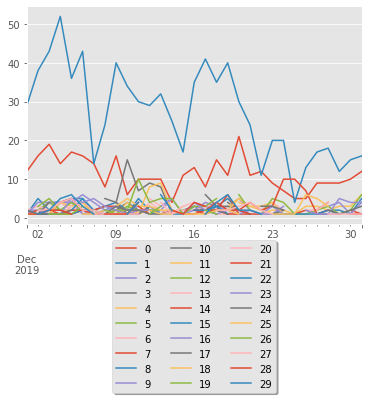

In [330]:
'''
Simply plot the data and move the legend
'''
ax = df2.plot()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

<h1><center> Building our own KMEANS Class </center></h1>

## The point of this section is to reinforce your understanding of KMeans

    Follow this link for the origin of the code: https://pythonprogramming.net/k-means-from-scratch-2-machine-learning-tutorial/?completed=/k-means-from-scratch-machine-learning-tutorial/

### The K_Means Class

In [122]:
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=300):
        '''
        Require three parameters:
        K Clusters
        Tolerance of whne to stop iterating for a new centroid
        Max iterations the class should take when fitting
        '''
        self.k = k #How many K's to use
        self.tol = tol #At what point do we stop iterating
        self.max_iter = max_iter #How many interations are the max

    def fit(self, data):

        self.centroids = {}
        for i in range(self.k):
            '''
            The first ith centroids are the first ith vectors in our data
            '''
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            '''
            Mapping of the cluster a record belongs to
            '''
            self.classifications = {}

            for i in range(self.k):
                '''
                Start with no classification
                '''
                self.classifications[i] = []

            for featureset in data:
                '''
                For a record in the data find the distance from itself to a center
                Loop through K centroids, finding the distance and store the dist in a list
                The classification becomes the centroid that has the min distance
                
                Append to self.classification (a dict) like this {centroid:record}
                '''
                
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances)) #A index as in a integer
                self.classifications[classification].append(featureset) # Ex: {3:[0,0,0....0,0,0]} where 3 is cluster 3

            prev_centroids = dict(self.centroids) #From when we stated self.centroid before the loop

            for classification in self.classifications: #The current classifications
                self.centroids[classification] = np.average(self.classifications[classification],axis=0) #New centroid is average of classifications

            optimized = True
            for c in self.centroids:
                '''
                Simply Set up to break loop if original, current centroids are close to eachother
                '''
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break
            

### Now let's test

In [123]:
clf = K_Means(k=30)

In [124]:
clf.fit(array)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


### Below we see the resulting final centroids

In [125]:
clf.centroids

{0: array([0.00090727, 0.        , 0.00072679, ..., 0.        , 0.        ,
        0.00061451]),
 1: array([0., 0., 0., ..., 0., 0., 0.]),
 2: array([0., 0., 0., ..., 0., 0., 0.]),
 3: array([0., 0., 0., ..., 0., 0., 0.]),
 4: array([0., 0., 0., ..., 0., 0., 0.]),
 5: array([0., 0., 0., ..., 0., 0., 0.]),
 6: array([0., 0., 0., ..., 0., 0., 0.]),
 7: array([0., 0., 0., ..., 0., 0., 0.]),
 8: array([0.        , 0.        , 0.        , ..., 0.00553982, 0.        ,
        0.        ]),
 9: array([0.        , 0.        , 0.        , ..., 0.        , 0.00173881,
        0.0014163 ]),
 10: array([0., 0., 0., ..., 0., 0., 0.]),
 11: array([0., 0., 0., ..., 0., 0., 0.]),
 12: array([0., 0., 0., ..., 0., 0., 0.]),
 13: array([0., 0., 0., ..., 0., 0., 0.]),
 14: array([0., 0., 0., ..., 0., 0., 0.]),
 15: array([0., 0., 0., ..., 0., 0., 0.]),
 16: array([0., 0., 0., ..., 0., 0., 0.]),
 17: array([0., 0., 0., ..., 0., 0., 0.]),
 18: array([0., 0., 0., ..., 0., 0., 0.]),
 19: array([0., 0., 0., .